# Navigation

---

This is the report for the Navigation lab on the Udacity DRLND. It trains an agent using Deep Q Learning.

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Initialize the Parameters For the Environment

In [2]:
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

### 3. Initialize the Agent and Train on the Environment

In [3]:
import gym
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


plt.ion()

#### The Model

The current model is very simple, with 2 hidden layers activated by relu and an action value layer.

The model was originally an adversarial model, with 3 base linear layers and a layer for projecting onto relative action value space and state value space. The hidden feature size for every layer was 128 and the hidden activation was elu. Each of these features were removed as they had a large negative impact.

#### The Agent

The agent is a deep q learning agent with a normal replay buffer using double DQN.

The Agent was a deep Q learning agent with a modified prioritized experience replay buffer. Notably the experience is reprioritized every time it is reviewed in training, with the new loss being used to compute the new priority. It also uses double DQN, using the Q values from the target network for computing next state values. The prioritized replay buffer was set to uniform sampling due to better performance.

In [4]:
from agent import BananaAgent

state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

agent = BananaAgent(state_size=state_size, action_size=action_size, learning_rate=0.0005, tau=0.001,
                    batch_size=64, buffer_size=10000, gamma=0.99, update_steps=4)

Episode 100	Average Score: 0.61
Episode 200	Average Score: 3.43
Episode 300	Average Score: 7.14
Episode 400	Average Score: 9.78
Episode 500	Average Score: 11.20
Episode 600	Average Score: 11.55
Episode 700	Average Score: 12.31
Episode 760	Average Score: 14.06
Environment fit in 660 episodes!	Average Score: 14.06


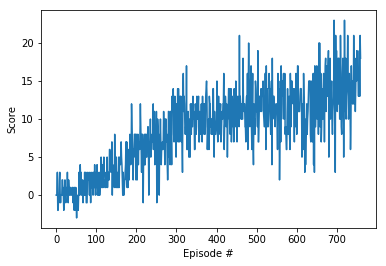

In [5]:
import torch.nn.functional as F

def dqn(n_episodes=2000, max_t=1000,
        eps_start=1.0, eps_end=0.01, eps_decay=0.995,
        a_start=1., a_end=1., a_decay=0.99,
        b_start=0., b_end=0., b_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    a = a_start
    b = b_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done, 1.-a, b)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        a = max(a_end, a_decay*a)
        b = max(b_end, b_decay*b)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 14:
            print('\nEnvironment fit in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Test on the Environment

In [ ]:
from agent import BananaAgent

state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

agent = BananaAgent(state_size=state_size, action_size=action_size, learning_rate=0.001,
                    batch_size=64, buffer_size=10000, gamma=0.9, update_steps=4)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0.01)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))